# ESPACIOS PROYECTIVOS Y MATRICES DE PROYECCIÓN

**Contenido**:
1. Coordenadas homogéneas
2. Matrices de proyección ortográfica y perspectiva
3. Crear objeto 3D
4. Visualizacion del cubo 3d original
5. Visualizacion de las 4 cámaras
6. Visualización de proyección perspectiva
7. Comparación: ortográfica vs perspectiva (vista isométrica)
8. Selector interactivo

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from ipywidgets import interact, Dropdown
import warnings
warnings.filterwarnings('ignore')

## 1. COORDENADAS HOMOGÉNEAS

In [2]:
def to_homogeneous(points):
    """Convierte puntos 3D a coordenadas homogéneas (añade w=1)"""
    if points.ndim == 1:
        return np.append(points, 1)
    return np.vstack([points, np.ones(points.shape[1])])

def from_homogeneous(points):
    """Convierte de coordenadas homogéneas a cartesianas (divide por w)"""
    if points.ndim == 1:
        return points[:-1] / points[-1]
    return points[:-1] / points[-1]

# Ejemplo
punto_3d = np.array([2, 3, 5])
punto_homogeneo = to_homogeneous(punto_3d)

print(f"\nPunto 3D cartesiano: {punto_3d}")
print(f"Punto homogéneo: {punto_homogeneo}")
print(f"De vuelta a cartesiano: {from_homogeneous(punto_homogeneo)}")


Punto 3D cartesiano: [2 3 5]
Punto homogéneo: [2 3 5 1]
De vuelta a cartesiano: [2. 3. 5.]


## 2. MATRICES DE PROYECCIÓN

In [3]:
def matriz_ortografica(left, right, bottom, top, near, far):
    """
    Crea una matriz de proyección ortográfica.
    Proyección paralela sin perspectiva.
    """
    M = np.zeros((4, 4))

    M[0, 0] = 2 / (right - left)
    M[1, 1] = 2 / (top - bottom)
    M[2, 2] = -2 / (far - near)
    M[3, 3] = 1

    M[0, 3] = -(right + left) / (right - left)
    M[1, 3] = -(top + bottom) / (top - bottom)
    M[2, 3] = -(far + near) / (far - near)

    return M

def matriz_perspectiva(fov, aspect, near, far):
    """
    Crea una matriz de proyección perspectiva.
    fov: campo de visión en grados
    aspect: relación de aspecto (ancho/alto)
    near, far: planos de recorte cercano y lejano
    """
    f = 1.0 / np.tan(np.radians(fov) / 2)

    M = np.zeros((4, 4))
    M[0, 0] = f / aspect
    M[1, 1] = f
    M[2, 2] = (far + near) / (near - far)
    M[2, 3] = (2 * far * near) / (near - far)
    M[3, 2] = -1

    return M

def matriz_vista(eye, target, up):
    """
    Crea una matriz de vista (view matrix).
    eye: posición de la cámara
    target: punto al que mira la cámara
    up: vector "arriba"
    """
    z = eye - target
    z = z / np.linalg.norm(z)

    x = np.cross(up, z)
    x = x / np.linalg.norm(x)

    y = np.cross(z, x)

    M = np.eye(4)
    M[0, :3] = x
    M[1, :3] = y
    M[2, :3] = z
    M[:3, 3] = -np.array([np.dot(x, eye), np.dot(y, eye), np.dot(z, eye)])

    return M

# Crear matrices
M_orto = matriz_ortografica(-5, 5, -5, 5, 0.1, 100)
M_persp = matriz_perspectiva(60, 1.0, 0.1, 100)

print("\n✓ Matriz Ortográfica creada (4x4)")
print(M_orto)
print("\n✓ Matriz Perspectiva creada (4x4)")
print(M_persp)


✓ Matriz Ortográfica creada (4x4)
[[ 0.2         0.          0.          0.        ]
 [ 0.          0.2         0.          0.        ]
 [ 0.          0.         -0.02002002 -1.002002  ]
 [ 0.          0.          0.          1.        ]]

✓ Matriz Perspectiva creada (4x4)
[[ 1.73205081  0.          0.          0.        ]
 [ 0.          1.73205081  0.          0.        ]
 [ 0.          0.         -1.002002   -0.2002002 ]
 [ 0.          0.         -1.          0.        ]]


## 3. CREAR OBJETO 3D (CUBO)

In [4]:
def crear_cubo(size=1):
    """Crea los vértices de un cubo"""
    s = size / 2
    vertices = np.array([
        [-s, -s, -s], [s, -s, -s], [s, s, -s], [-s, s, -s],  # Cara trasera
        [-s, -s, s],  [s, -s, s],  [s, s, s],  [-s, s, s]    # Cara frontal
    ]).T

    # Aristas del cubo
    edges = [
        [0, 1], [1, 2], [2, 3], [3, 0],  # Cara trasera
        [4, 5], [5, 6], [6, 7], [7, 4],  # Cara frontal
        [0, 4], [1, 5], [2, 6], [3, 7]   # Conexiones
    ]

    return vertices, edges

def proyectar_puntos(vertices, M_view, M_proj):
    """Proyecta vértices 3D usando matrices de vista y proyección"""
    vertices_h = to_homogeneous(vertices)
    vertices_view = M_view @ vertices_h
    vertices_proj = M_proj @ vertices_view
    vertices_2d = from_homogeneous(vertices_proj)

    return vertices_2d, vertices_view[2]

# Crear cubo
vertices_cubo, edges_cubo = crear_cubo(2)

# Configurar cámaras
cameras = {
    'Frontal': {
        'eye': np.array([0, 0, 10]),
        'target': np.array([0, 0, 0]),
        'up': np.array([0, 1, 0])
    },
    'Superior': {
        'eye': np.array([0, 10, 0]),
        'target': np.array([0, 0, 0]),
        'up': np.array([0, 0, -1])
    },
    'Lateral': {
        'eye': np.array([10, 0, 0]),
        'target': np.array([0, 0, 0]),
        'up': np.array([0, 1, 0])
    },
    'Isométrica': {
        'eye': np.array([7, 7, 7]),
        'target': np.array([0, 0, 0]),
        'up': np.array([0, 1, 0])
    }
}

print("\n" + "="*70)
print("3. CUBO 3D CREADO")
print("="*70)
print(f"Vértices: {vertices_cubo.shape[1]}")
print(f"Aristas: {len(edges_cubo)}")
print(f"Cámaras configuradas: {len(cameras)}")


3. CUBO 3D CREADO
Vértices: 8
Aristas: 12
Cámaras configuradas: 4


## 4. VISUALIZACIÓN: CUBO 3D ORIGINAL

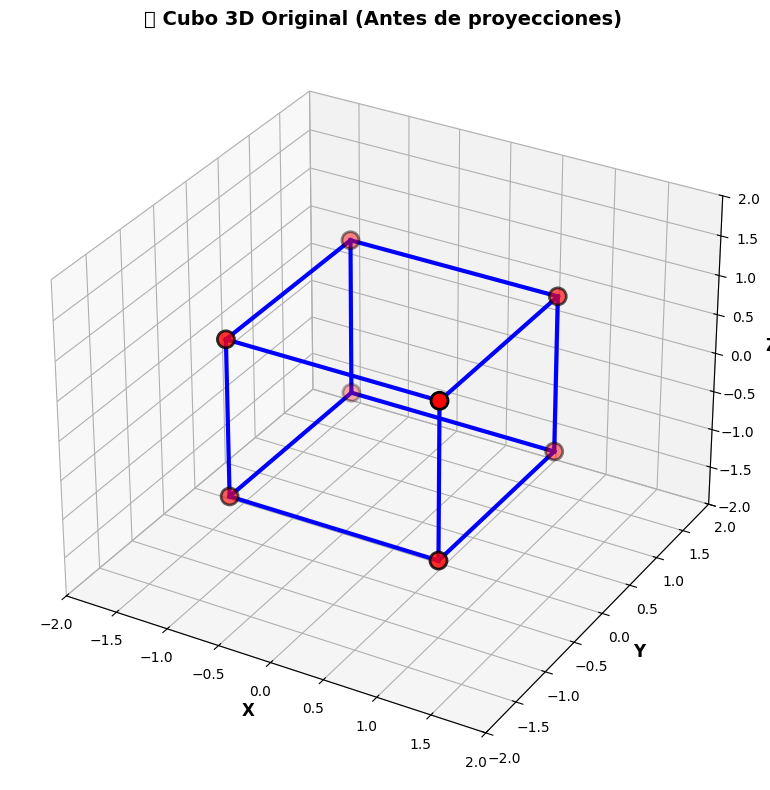

In [5]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Dibujar cubo
for edge in edges_cubo:
    p1, p2 = vertices_cubo[:, edge[0]], vertices_cubo[:, edge[1]]
    ax.plot([p1[0], p2[0]], [p1[1], p2[1]], [p1[2], p2[2]], 'b-', linewidth=3)

ax.scatter(vertices_cubo[0], vertices_cubo[1], vertices_cubo[2],
           c='red', s=150, depthshade=True, edgecolors='black', linewidths=2)

ax.set_xlabel('X', fontsize=12, fontweight='bold')
ax.set_ylabel('Y', fontsize=12, fontweight='bold')
ax.set_zlabel('Z', fontsize=12, fontweight='bold')
ax.set_title('🎲 Cubo 3D Original (Antes de proyecciones)', fontsize=14, fontweight='bold')

max_range = 2
ax.set_xlim([-max_range, max_range])
ax.set_ylim([-max_range, max_range])
ax.set_zlim([-max_range, max_range])

plt.tight_layout()
plt.show()



## 5. VISUALIZACIÓN: TODAS LAS VISTAS (4 CÁMARAS)

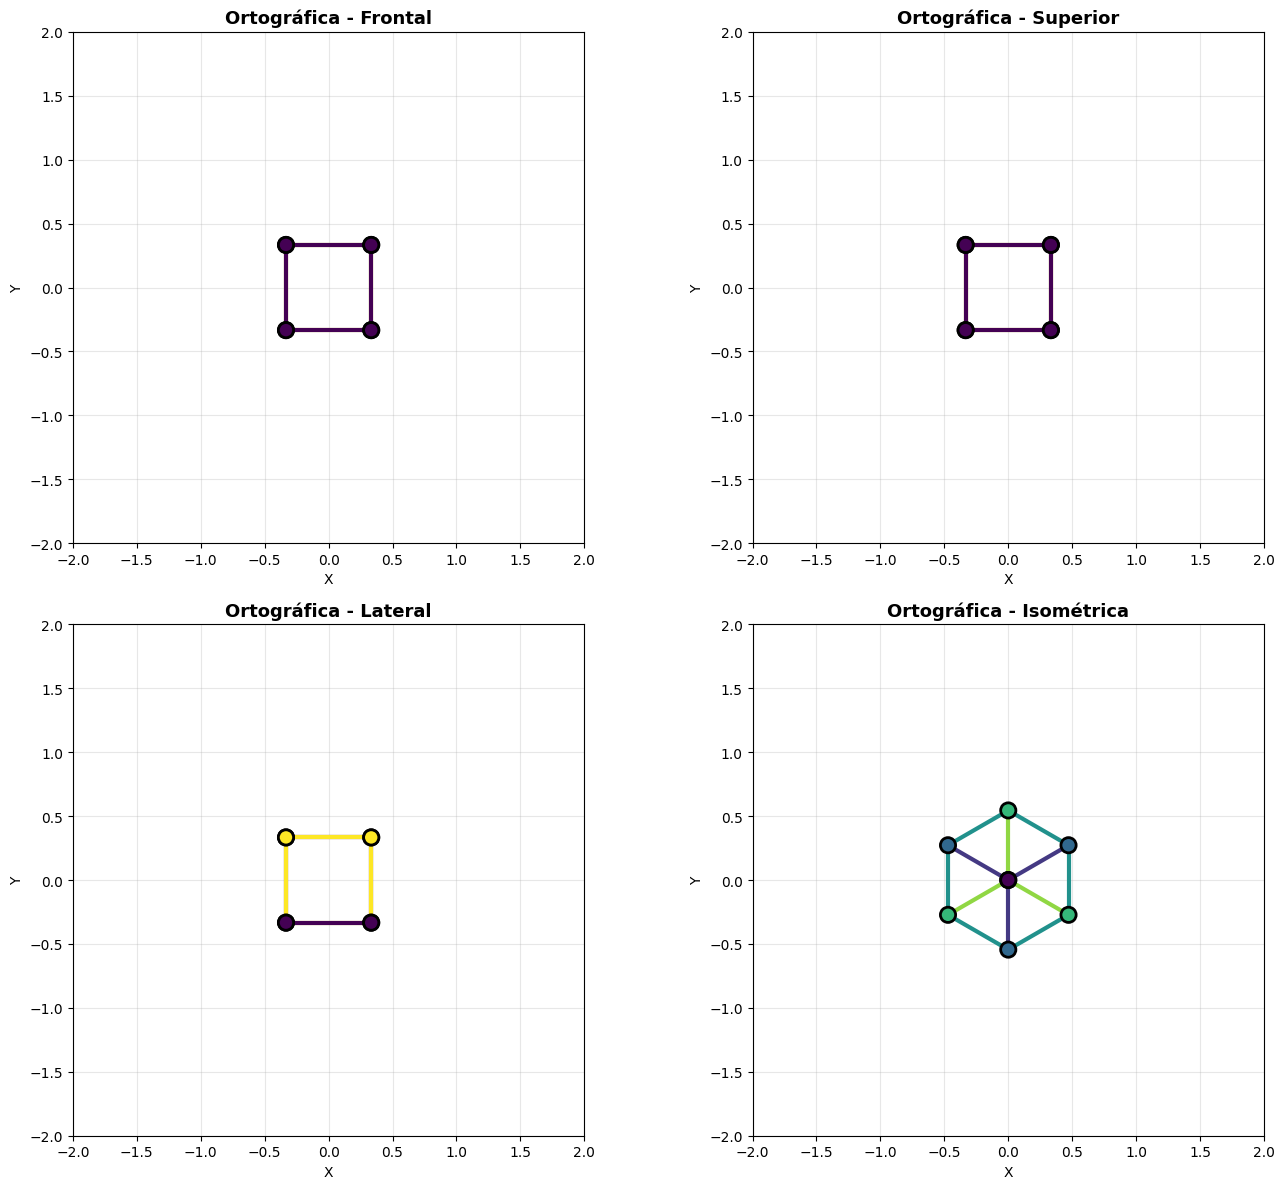

In [6]:
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten()

for idx, (nombre, cam) in enumerate(cameras.items()):
    ax = axes[idx]

    # Matrices
    M_view = matriz_vista(cam['eye'], cam['target'], cam['up'])
    M_proj = matriz_ortografica(-3, 3, -3, 3, 0.1, 20)

    # Proyectar
    vertices_2d, depth = proyectar_puntos(vertices_cubo, M_view, M_proj)

    # Normalizar profundidad para colores
    depth_norm = (depth - depth.min()) / (depth.max() - depth.min() + 1e-6)

    # Dibujar aristas con colores por profundidad
    for edge in edges_cubo:
        p1, p2 = vertices_2d[:, edge[0]], vertices_2d[:, edge[1]]
        depth_avg = (depth_norm[edge[0]] + depth_norm[edge[1]]) / 2
        color = plt.cm.viridis(1 - depth_avg)
        ax.plot([p1[0], p2[0]], [p1[1], p2[1]], 'o-', color=color, linewidth=3, markersize=8)

    # Dibujar vértices
    colors = plt.cm.viridis(1 - depth_norm)
    ax.scatter(vertices_2d[0], vertices_2d[1], c=colors, s=120, zorder=5,
               edgecolors='black', linewidths=2)

    ax.set_xlim(-2, 2)
    ax.set_ylim(-2, 2)
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)
    ax.set_title(f'Ortográfica - {nombre}', fontsize=13, fontweight='bold')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')

plt.tight_layout()
plt.show()


## 6. VISUALIZACIÓN: PROYECCIÓN PERSPECTIVA

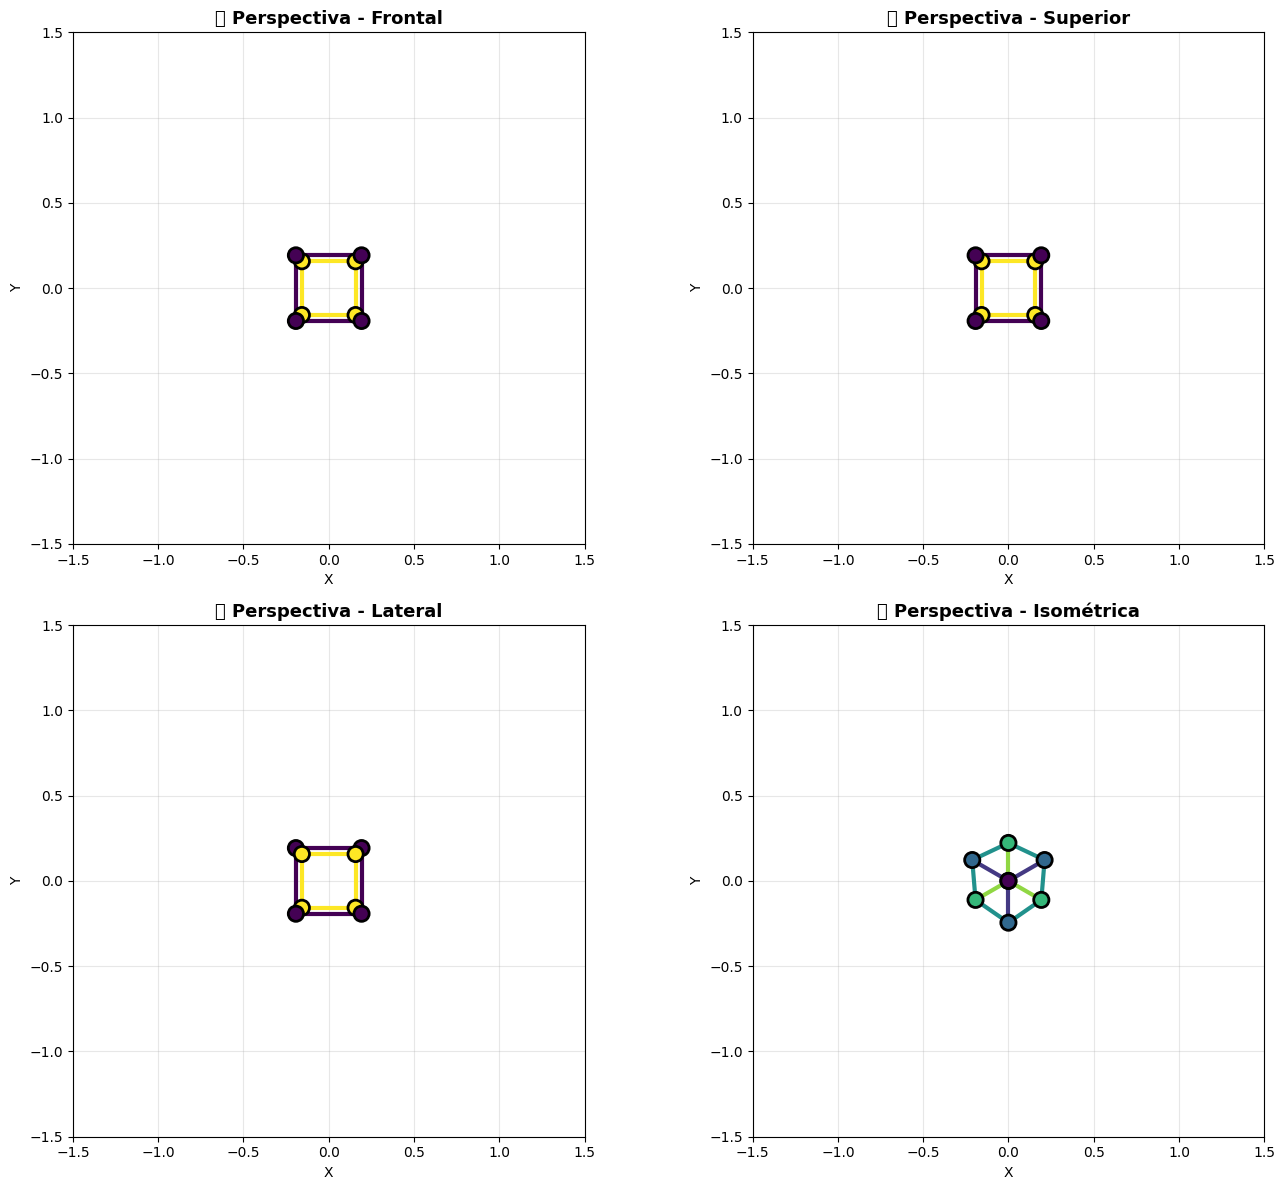

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten()

for idx, (nombre, cam) in enumerate(cameras.items()):
    ax = axes[idx]

    # Matrices
    M_view = matriz_vista(cam['eye'], cam['target'], cam['up'])
    M_proj = matriz_perspectiva(60, 1.0, 0.1, 20)

    # Proyectar
    vertices_2d, depth = proyectar_puntos(vertices_cubo, M_view, M_proj)

    # Normalizar profundidad para colores
    depth_norm = (depth - depth.min()) / (depth.max() - depth.min() + 1e-6)

    # Dibujar aristas con colores por profundidad
    for edge in edges_cubo:
        p1, p2 = vertices_2d[:, edge[0]], vertices_2d[:, edge[1]]
        depth_avg = (depth_norm[edge[0]] + depth_norm[edge[1]]) / 2
        color = plt.cm.viridis(1 - depth_avg)
        ax.plot([p1[0], p2[0]], [p1[1], p2[1]], 'o-', color=color, linewidth=3, markersize=8)

    # Dibujar vértices
    colors = plt.cm.viridis(1 - depth_norm)
    ax.scatter(vertices_2d[0], vertices_2d[1], c=colors, s=120, zorder=5,
               edgecolors='black', linewidths=2)

    ax.set_xlim(-1.5, 1.5)
    ax.set_ylim(-1.5, 1.5)
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)
    ax.set_title(f'👁️ Perspectiva - {nombre}', fontsize=13, fontweight='bold')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')

plt.tight_layout()
plt.show()



## 7. COMPARACIÓN: Ortográfica vs Perspectiva (Vista Isométrica)

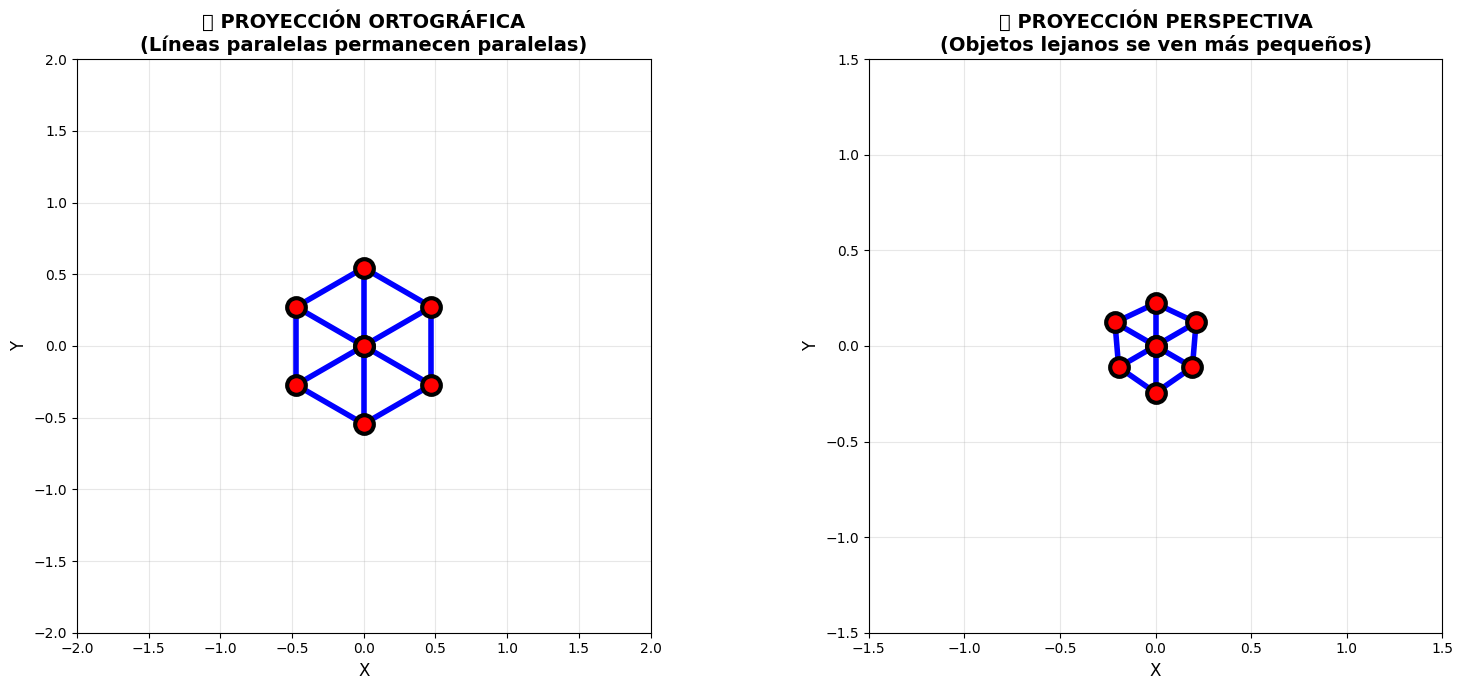

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

# Vista isométrica
cam = cameras['Isométrica']
M_view = matriz_vista(cam['eye'], cam['target'], cam['up'])

# Subplot 1: Ortográfica
M_orto = matriz_ortografica(-3, 3, -3, 3, 0.1, 20)
vertices_2d_orto, depth_orto = proyectar_puntos(vertices_cubo, M_view, M_orto)

for edge in edges_cubo:
    p1, p2 = vertices_2d_orto[:, edge[0]], vertices_2d_orto[:, edge[1]]
    ax1.plot([p1[0], p2[0]], [p1[1], p2[1]], 'b-', linewidth=4)

ax1.scatter(vertices_2d_orto[0], vertices_2d_orto[1], c='red', s=180, zorder=5,
            edgecolors='black', linewidths=3)
ax1.set_xlim(-2, 2)
ax1.set_ylim(-2, 2)
ax1.set_aspect('equal')
ax1.grid(True, alpha=0.3)
ax1.set_title('📐 PROYECCIÓN ORTOGRÁFICA\n(Líneas paralelas permanecen paralelas)',
              fontsize=14, fontweight='bold')
ax1.set_xlabel('X', fontsize=12)
ax1.set_ylabel('Y', fontsize=12)

# Subplot 2: Perspectiva
M_persp = matriz_perspectiva(60, 1.0, 0.1, 20)
vertices_2d_persp, depth_persp = proyectar_puntos(vertices_cubo, M_view, M_persp)

for edge in edges_cubo:
    p1, p2 = vertices_2d_persp[:, edge[0]], vertices_2d_persp[:, edge[1]]
    ax2.plot([p1[0], p2[0]], [p1[1], p2[1]], 'b-', linewidth=4)

ax2.scatter(vertices_2d_persp[0], vertices_2d_persp[1], c='red', s=180, zorder=5,
            edgecolors='black', linewidths=3)
ax2.set_xlim(-1.5, 1.5)
ax2.set_ylim(-1.5, 1.5)
ax2.set_aspect('equal')
ax2.grid(True, alpha=0.3)
ax2.set_title('👁️ PROYECCIÓN PERSPECTIVA\n(Objetos lejanos se ven más pequeños)',
              fontsize=14, fontweight='bold')
ax2.set_xlabel('X', fontsize=12)
ax2.set_ylabel('Y', fontsize=12)

plt.tight_layout()
plt.show()

## 8. SELECTOR INTERACTIVO

In [9]:
def mostrar_proyeccion(Cámara='Frontal', Tipo='Ortográfica'):
    """Función interactiva para cambiar entre cámaras y proyecciones"""

    fig, ax = plt.subplots(figsize=(10, 8))

    # Obtener cámara
    cam = cameras[Cámara]
    M_view = matriz_vista(cam['eye'], cam['target'], cam['up'])

    # Obtener proyección
    if Tipo == 'Ortográfica':
        M_proj = matriz_ortografica(-3, 3, -3, 3, 0.1, 20)
        xlim, ylim = (-2, 2), (-2, 2)
        icono = '📐'
    else:
        M_proj = matriz_perspectiva(60, 1.0, 0.1, 20)
        xlim, ylim = (-1.5, 1.5), (-1.5, 1.5)
        icono = '👁️'

    # Proyectar
    vertices_2d, depth = proyectar_puntos(vertices_cubo, M_view, M_proj)

    # Normalizar profundidad
    depth_norm = (depth - depth.min()) / (depth.max() - depth.min() + 1e-6)

    # Dibujar aristas con colores
    for edge in edges_cubo:
        p1, p2 = vertices_2d[:, edge[0]], vertices_2d[:, edge[1]]
        depth_avg = (depth_norm[edge[0]] + depth_norm[edge[1]]) / 2
        color = plt.cm.viridis(1 - depth_avg)
        ax.plot([p1[0], p2[0]], [p1[1], p2[1]], 'o-', color=color, linewidth=4, markersize=10)

    # Dibujar vértices
    colors = plt.cm.viridis(1 - depth_norm)
    ax.scatter(vertices_2d[0], vertices_2d[1], c=colors, s=200, zorder=5,
               edgecolors='black', linewidths=3)

    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3, linewidth=1.5)
    ax.set_title(f'{icono} {Tipo} - Cámara {Cámara}', fontsize=16, fontweight='bold', pad=20)
    ax.set_xlabel('X', fontsize=13)
    ax.set_ylabel('Y', fontsize=13)

    # Añadir barra de color para profundidad
    sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label('Profundidad (cerca → lejos)', rotation=270, labelpad=20, fontsize=11)

    plt.tight_layout()
    plt.show()

# Crear selector interactivo
interact(mostrar_proyeccion,
         Cámara=['Frontal', 'Superior', 'Lateral', 'Isométrica'],
         Tipo=['Ortográfica', 'Perspectiva'])

print("\n Selector interactivo creado")


interactive(children=(Dropdown(description='Cámara', options=('Frontal', 'Superior', 'Lateral', 'Isométrica'),…


 Selector interactivo creado
